Reference: https://towardsdatascience.com/time-series-in-python-exponential-smoothing-and-arima-processes-2c67f2a52788

In [1]:
import requests
import pandas as pd
import json
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt
import numpy as np

In [2]:
%matplotlib inline
plt.style.use('Solarize_Light2')

In [3]:
import yfinance as yf

In [43]:
from functools import reduce

In [95]:
# train test split
y = yf.Ticker('SPY')
time_period = "6mo"
all_data = y.history(period=time_period)
df = all_data[['Close']]

percent = .9
train_test_split = int(all_data.shape[0]*percent)

train = df.iloc[:train_test_split,]
test = df.iloc[train_test_split:,]

train = train.asfreq('b')
train.index = pd.to_datetime(train.index)

train = reduce(lambda d, _: d.fillna(d.rolling(3, min_periods=3).mean().shift()), range(train['Close'].isna().sum()), train)

test = test.asfreq('b')
test.index = pd.to_datetime(test.index)

test = reduce(lambda d, _: d.fillna(d.rolling(3, min_periods=3).mean().shift()), range(test['Close'].isna().sum()), test)


print('train set')
display(train)
print('test set')
display(test)

# prediction
pred = test.copy()

train set


,Close
Date,
2022-11-14 00:00:00-05:00,391.818512
2022-11-15 00:00:00-05:00,395.160339
2022-11-16 00:00:00-05:00,392.145752
2022-11-17 00:00:00-05:00,390.945862
2022-11-18 00:00:00-05:00,392.720917
...,...
2023-04-19 00:00:00-04:00,414.140015
2023-04-20 00:00:00-04:00,411.880005
2023-04-21 00:00:00-04:00,412.200012


test set


,Close
Date,
2023-04-26 00:00:00-04:00,404.359985
2023-04-27 00:00:00-04:00,412.410004
2023-04-28 00:00:00-04:00,415.929993
2023-05-01 00:00:00-04:00,415.510010
2023-05-02 00:00:00-04:00,410.839996
2023-05-03 00:00:00-04:00,408.019989
2023-05-04 00:00:00-04:00,405.130005
2023-05-05 00:00:00-04:00,412.630005
2023-05-08 00:00:00-04:00,412.739990


In [96]:
model = SimpleExpSmoothing(np.asarray(train['Close']))
model._index = pd.to_datetime(train.index)
print(type(model))

<class 'statsmodels.tsa.holtwinters.model.SimpleExpSmoothing'>


/opt/homebrew/lib/python3.11/site-packages/pandas/util/_decorators.py:210: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)
/opt/homebrew/lib/python3.11/site-packages/pandas/util/_decorators.py:210: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)


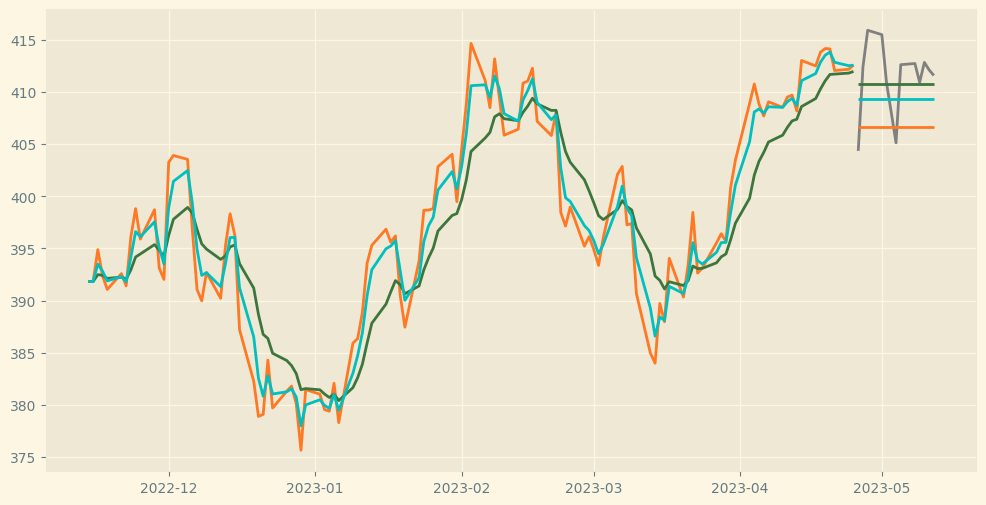

In [97]:
# try with only one
fit1 = model.fit()
pred1 = fit1.forecast(test.shape[0])
fit2 = model.fit(smoothing_level=.2)
pred2 = fit2.forecast(test.shape[0])
fit3 = model.fit(smoothing_level=.5)
pred3 = fit3.forecast(test.shape[0])

fig, ax = plt.subplots(figsize=(12, 6))

ind_train = train.shape[0]

ax.plot(train.index[ind_train:], train.values[ind_train:])
ax.plot(test.index, test.values, color="gray")

for p, f, c in zip((pred1, pred2, pred3),(fit1, fit2, fit3),('#ff7823','#3c763d','c')):
    ax.plot(train.index[:ind_train], f.fittedvalues[:ind_train], color=c)
    forecasted_val_range = p.shape[0] if p.shape[0] < test.shape[0] else test.shape[0]
    ax.plot(test.index[:forecasted_val_range], p[:forecasted_val_range], color=c)

In [8]:
fit1 = model.fit()
pred1 = fit1.forecast(1)
fit2 = model.fit(smoothing_level=.2)
pred2 = fit2.forecast(1)
fit3 = model.fit(smoothing_level=.5)
pred3 = fit3.forecast(1)

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/pandas/util/_decorators.py:210: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)
/opt/homebrew/lib/python3.11/site-packages/pandas/util/_decorators.py:210: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)


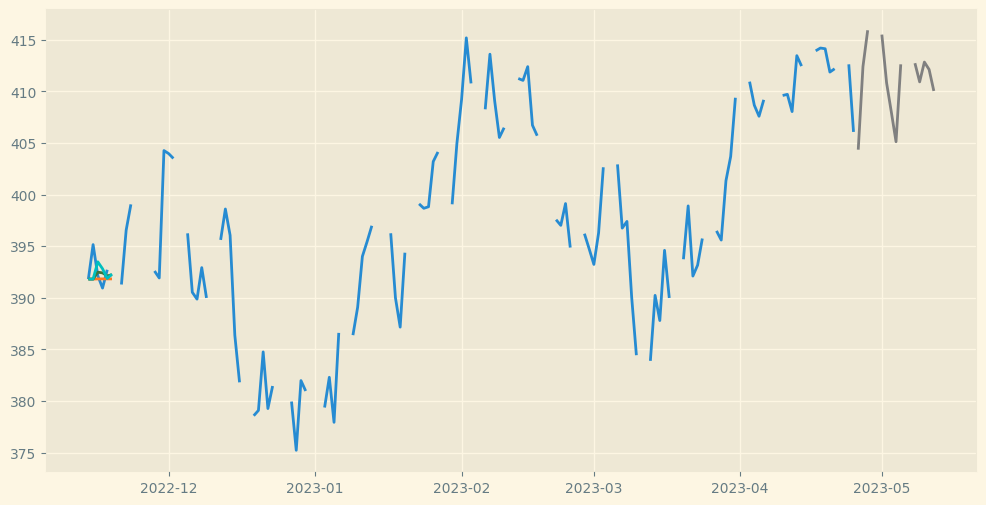

In [17]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train.index[0:], train.values[0:])
ax.plot(test.index, test.values, color="gray")
for p, f, c in zip((pred1, pred2, pred3),(fit1, fit2, fit3),('#ff7823','#3c763d','c')):
    ax.plot(train.index[:train.shape[0]], f.fittedvalues[:], color=c)